In [1]:
!pip install pyspark

In [2]:
import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext, functions as F
from pyspark.sql.functions import *
from urllib.parse import urlparse

In [ ]:
print(pyspark.__version__)

In [4]:
import os
import sys 
os.environ['HADOOP_HOME']=r"C:\apps\hadoop"
os.environ["JAVA_HOME"] = r"C:\Program Files\Java\jdk-11.0.15"
os.environ["SPARK_HOME"] = r"C:\apps\spark-3.3.0-bin-hadoop3"
sys.path.append("C:\apps\hadoop\bin")

# 1. Import data into MongoDB
Using MongoDB Compass to import 2 datasets into same database named "depx303_asm1" and 2 separate collections: questions and answers.
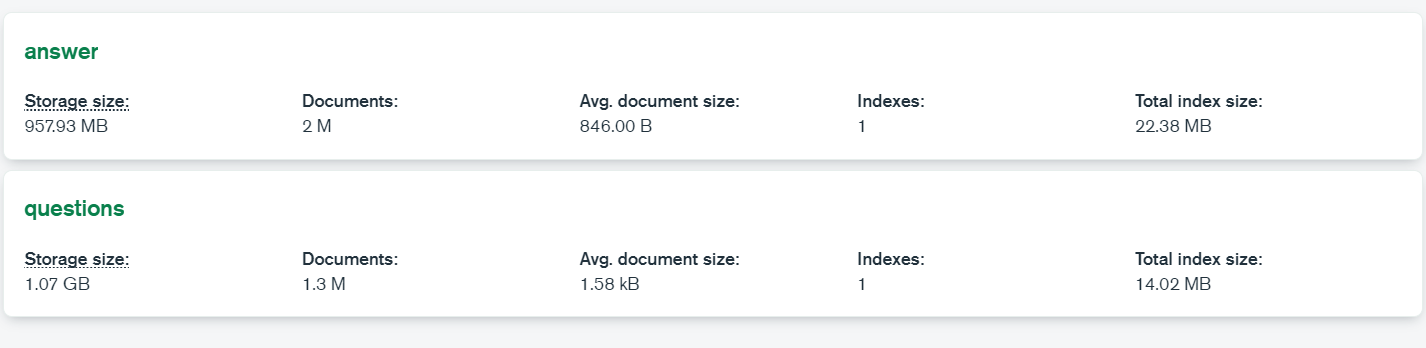

# 2. Read data from MongoDB with PySpark

In [5]:
# create a spark session
spark = SparkSession \
    .builder \
    .master("local") \
    .appName("asm1") \
    .config("spark.driver.memory", "15g") \
    .config("spark.mongodb.read.connection.uri", "mongodb://localhost:27017/depx303_asm1") \
    .config("spark.mongodb.write.connection.uri", "mongodb://localhost:27017/depx303_asm1") \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector:10.0.2') \
    .getOrCreate()

In [7]:
# read data from mongodb collection "questions" into a dataframe "df"
df = spark.read \
          .format("mongodb") \
          .option("uri", "mongodb://localhost:27017/depx303_asm1") \
          .option("database", "depx303_asm1") \
          .option("collection", "questions") \
          .load()

df.printSchema()

root
 |-- Body: string (nullable = true)
 |-- ClosedDate: timestamp (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: integer (nullable = true)
 |-- OwnerUserId: double (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- _id: string (nullable = true)



# 3. Data pre-processing

In [8]:
# Change data types of some columns to match the requirement

# change from double to integer
df = df.withColumn("OwnerUserId", col("OwnerUserId").cast('integer'))

# change from timestamp to date
df = df.withColumn("ClosedDate", to_date("ClosedDate"))
df = df.withColumn("CreationDate", to_date("CreationDate"))
df.printSchema()

root
 |-- Body: string (nullable = true)
 |-- ClosedDate: date (nullable = true)
 |-- CreationDate: date (nullable = true)
 |-- Id: integer (nullable = true)
 |-- OwnerUserId: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- _id: string (nullable = true)



# 4. Data Analysis
## 4.1. Count the amount of time a coding language appears in questions' body

In [9]:
# create a new df containing a frequency table of all programming languages
coding_lang_freq = df \
    .withColumnRenamed("Body","Programing Language") \
    .withColumn("Programing Language",  
                F.regexp_extract(lower(col("Programing Language")), 
                r"(java|python|c\+\+|c\#|(?<![\w.])go(?![.\w])|ruby|javascript|php|(?<![\w.])html(?![.\w])|css|sql)", 
                0)) \
    .groupBy("Programing Language")\
    .count() \
    .filter(col("Programing Language") != "")\
    .show()

## 4.2. Find the most used domain in questions' body

In [116]:
# create a new df containing the frequency of domain names
# appearing in the questions' body 
domain_freq = df \
    .withColumnRenamed("Body","Domain") \
    .withColumn("Domain", # use regex to extract domain name of URL
                F.regexp_extract(col("Domain"), 
                r"(?<=http:\/\/)(.*?\.(edu|com|net|org|info|coop|int|co\.uk|co\.us|co\.ca|org\.uk|ac\.uk|uk|us))",
                0))\
    .groupBy("Domain")\
    .count()\
    .show(10, truncate = False)

+-----------------------+-----+
|Domain                 |count|
+-----------------------+-----+
|groups.csail.mit.edu   |4    |
|fiddlertool.com        |1    |
|img7.imageshack.us     |3    |
|ohdave.com             |1    |
|www.olympianbot.co.uk  |1    |
|feeds2.feedburner.com  |2    |
|www.twitpocalypse.com  |1    |
|taksi.sourceforge.net  |1    |
|www.amateurinmotion.com|1    |
|www.cnbtn.com          |1    |
+-----------------------+-----+
only showing top 10 rows



## 4.3. Total score of users by users and day

In [117]:
# use aggregation groupby and sum function 
# to get total scores by users and date
# sort by userid and date both in ascending order
scores_by_day = df.select(col("OwnerUserId"), col("CreationDate"), 
                          col("Score")) \
                  .groupby("OwnerUserId", "CreationDate") \
                  .agg(F.sum("Score").alias("TotalScore")) \
                  .sort(asc("OwnerUserId"), asc("CreationDate")) \
                  .show(5)

+-----------+------------+----------+
|OwnerUserId|CreationDate|TotalScore|
+-----------+------------+----------+
|          0|  2008-08-07|         9|
|          0|  2008-08-15|         6|
|          0|  2008-08-18|         2|
|          0|  2008-08-20|         0|
|          0|  2008-08-27|         5|
+-----------+------------+----------+
only showing top 5 rows



## 4.4. Total score of each user in specific period of time

In [118]:
START = '2008-01-01'
END = '2009-01-01'

# filter date from start to end date
# with aggregation groupby and sum function
# to get total score of each user in a span of time
score_by_period = df \
    .select(col("OwnerUserId"), col("Score"), col("CreationDate")) \
    .filter(col("CreationDate") > START).filter(col("CreationDate")< END) \
    .groupby("OwnerUserId") \
    .agg(F.sum("Score").alias("TotalScore")) \
    .show(5)

+-----------+----------+
|OwnerUserId|TotalScore|
+-----------+----------+
|       1580|         5|
|      18051|         2|
|       4101|        11|
|      18866|         6|
|    2376109|         5|
+-----------+----------+
only showing top 5 rows



## 4.5. Find all questions that have more than 5 answers (Bucket join)

In [ ]:
# read data from answer collection to df "answers"
answers = spark.read \
          .format("mongodb") \
          .option("uri", "mongodb://localhost:27017/depx303_asm1") \
          .option("database", "depx303_asm1") \
          .option("collection", "answer") \
          .load()

answers.printSchema()

root
 |-- Body: string (nullable = true)
 |-- CreationDate: timestamp (nullable = true)
 |-- Id: integer (nullable = true)
 |-- OwnerUserId: double (nullable = true)
 |-- ParentId: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- _id: string (nullable = true)



In [ ]:
# Change data types of some column to match the requirement in 'df' dateframe
answers = answers.withColumn("CreationDate", to_date("CreationDate"))
answers = answers.withColumn("OwnerUserId", col("OwnerUserId").cast('integer'))
answers.printSchema()

root
 |-- Body: string (nullable = true)
 |-- CreationDate: date (nullable = true)
 |-- Id: integer (nullable = true)
 |-- OwnerUserId: integer (nullable = true)
 |-- ParentId: integer (nullable = true)
 |-- Score: integer (nullable = true)
 |-- _id: string (nullable = true)



In [ ]:
# create a new database if not exists
spark.sql("CREATE DATABASE IF NOT EXISTS MY_DB")
spark.sql("USE MY_DB")

DataFrame[]

In [ ]:
# use bucket join to join 2 dataframes 

# write data from df to parquet table 
df.write.bucketBy(10, "Id") \
    .format("parquet") \
    .mode("overwrite")\
    .option("path", r"C:\apps\pyspark_output")\
    .saveAsTable("MY_DB.questions")

# write data from answers dataframe to parquet table 
answers.write \
    .bucketBy(10, "ParentId") \
    .format("parquet") \
    .mode("overwrite") \
    .option("path", r"C:\apps\output1")\
    .saveAsTable("MY_DB.answers1")

In [ ]:
df3 = spark.read.table("MY_DB.questions")
df4 = spark.read.table("MY_DB.answers1")

spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

# change column name to eliminate column name ambiguity
df3_renamed = df3.withColumnRenamed("Id", "QuestionID")
df3_renamed_2 = df3_renamed.withColumnRenamed("OwnerUserId", "PersonAskedID")
df3_renamed_3 = df3_renamed_2.withColumnRenamed("Score", "ScoreAsked")
df3_renamed_4 = df3_renamed_3.withColumnRenamed("CreationDate", "AskedCreationDate")

# join answers df to df3_renamed df
join_expr = df3_renamed_4.QuestionID == df4.ParentId
df3_renamed_4.join(df4, join_expr, "inner").show(20)

+--------------------+----------+-----------------+----------+-------------+----------+--------------------+--------------------+--------------------+------------+-------+-----------+--------+-----+--------------------+
|                Body|ClosedDate|AskedCreationDate|QuestionID|PersonAskedID|ScoreAsked|               Title|                 _id|                Body|CreationDate|     Id|OwnerUserId|ParentId|Score|                 _id|
+--------------------+----------+-----------------+----------+-------------+----------+--------------------+--------------------+--------------------+------------+-------+-----------+--------+-----+--------------------+
|<p>Are there any ...|2012-12-26|       2008-08-01|        90|           58|       144|Good branching an...|62c599bbf343c0353...|<p><a href="http:...|  2008-08-01|     92|         61|      90|   13|62c5b044f343c0353...|
|<p>Are there any ...|2012-12-26|       2008-08-01|        90|           58|       144|Good branching an...|62c599bbf343

In [ ]:
# all questions that have more than 5 answers
result = df3_renamed_4.join(df4, join_expr, "inner") \
       .select("QuestionID", "Id") \
       .groupBy("QuestionID") \
       .agg(F.count("Id").alias("TotalAnswers")) \
       .filter(col("TotalAnswers") > 5) \
       .sort(asc("QuestionID")) \


+----------+------------+
|QuestionID|TotalAnswers|
+----------+------------+
|       180|           9|
|       260|           9|
|       330|          10|
|       580|          14|
|       650|           6|
+----------+------------+
only showing top 5 rows



## 4.6. (Advanced) Find all active users ( more than 50 answers or total scores for answers > 500 or having more than 5 answers on the same day the question is created)

In [90]:
# create a temp View on the joined dataframe to later query by sparkSQL
# select some columns only
df3_renamed_4.join(df4, join_expr, "inner") \
            .select("QuestionID", "Id", "OwnerUserId", "Score", "AskedCreationDate", "CreationDate")\
            .createTempView("Needed")

In [110]:
# find all active users that meet the requirement
active_users = spark.sql("""
    select OwnerUserId, 
           count(Id) as TotalAnswers, 
           sum(Score) as TotalScore
    from needed
    group by OwnerUserId
    having count(Id) > 50 or sum(Score) > 500
        or OwnerUserId in (select OwnerUserId
                           from needed
                           group by QuestionID, AskedCreationDate, OwnerUserId, CreationDate
                           having count(Id) > 5 and AskedCreationDate = CreationDate)
    
""").show(50)

+-----------+------------+----------+
|OwnerUserId|TotalAnswers|TotalScore|
+-----------+------------+----------+
|          0|       13200|     33920|
|         13|         208|      1419|
|         29|          42|      1729|
|         60|          56|       377|
|         67|         120|       846|
|         77|          46|      1099|
|         91|          68|       543|
|        142|           3|       593|
|        157|          24|      1759|
|        184|          11|       636|
|        267|         263|      2480|
|        304|         123|       446|
|        312|           8|       632|
|        357|          12|       672|
|        369|         111|       432|
|        372|          52|       244|
|        377|          59|       204|
|        419|         112|       404|
|        456|          54|       260|
|        459|          35|       621|
|        476|         693|      2581|
|        572|          56|       339|
|        582|         137|       832|
|        615